In [13]:
import oda_api.token 
import logging
import numpy as np
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage, OdaLightCurve, OdaSpectrum
import matplotlib.pyplot as plt
import astroquery.heasarc
from astropy.wcs import WCS
from astropy.io import fits
from astroquery.simbad import Simbad
from astropy import coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib.patches import Circle
from astroquery.jplhorizons import Horizons
import pandas as pd
import astropy.units as u
import json

In [14]:
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

Load the ScWs.

In [15]:
scw = []
start = []
end = []

with open("../data/Crab-ScWs.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(", ")
        scw.append(parts[0])
        start.append(float(parts[1]))  
        end.append(float(parts[2]))  

unique_sorted_data = {}
for scw, start, end in sorted(zip(scw, start, end), key=lambda x: x[0]):
    if scw not in unique_sorted_data:  
        unique_sorted_data[scw] = (scw, start, end)

scw, start, end = map(list, zip(*unique_sorted_data.values()))
durations = [e-s for e,s in zip(end, start)]

In [19]:
crab = SkyCoord.from_name("Crab")
ra = crab.ra.deg
dec = crab.dec.deg

## QUERYING 

As we can see, Crab observations only happen twice per year in 3-month groups (Feb->Apr and Aug->Oct).
The idea now will be to get some longterm lightcurves over the years and see how the countrate evolves. Depending on the variability of the countrate, we will use it for flux conversion.

In [20]:
api_cat={
    "cat_frame": "fk5",
    "cat_coord_units": "deg",
    "cat_column_list": [
        [0],
        ["Crab"],
        [125.4826889038086],
        [ra],
        [dec],
        [-32768],
        [2],
        [0],
        [0.0002800000074785203]],
    "cat_column_names": [
        "meta_ID",
        "src_names",
        "significance",
        "ra",
        "dec",
        "NEW_SOURCE",
        "ISGRI_FLAG",
        "FLAG",
        "ERR_RAD"
    ],
    "cat_column_descr":
        [
            ["meta_ID", "<i8"],
            ["src_names", "<U11"],
            ["significance", "<f8"],
            ["ra", "<f8"],
            ["dec", "<f8"],
            ["NEW_SOURCE", "<i8"],
            ["ISGRI_FLAG", "<i8"],
            ["FLAG", "<i8"],
            ["ERR_RAD", "<f8"]
        ],
    "cat_lat_name": "dec",
    "cat_lon_name": "ra"
}

## IMAGES

We use asynchronous querying. We aim to get one result per month, every year. Since the ScWs only happen in two 3-month intervals per year, this will mean 6 results every year for 22 years so 120 results total. 

To choose the ScW every month, we will take the shortest one for time reasons.

In [21]:
isot_start_times = Time(start, format='mjd').isot
isot_end_times = Time(end, format='mjd').isot
duration_seconds = [duration * 86400 for duration in durations]
year_months = [st[:7] for st in isot_start_times]

In [28]:
disp_by_date = {}
data_by_date = {}

while True:
    image_results = []

    for year_month in set(year_months):

        filtered_scws = []
        for i, year_month_in_list in enumerate(year_months):
            if year_month_in_list == year_month:
                filtered_scws.append((scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i]))

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue
        
        min_duration_scw = min(filtered_scws, key=lambda x: x[3]) # minimum duration
        scw_id, start_time, end_time, duration = min_duration_scw
        print(min_duration_scw)

        par_dict = {
            "RA": ra,
            "DEC": dec,
            "E1_keV": "15",
            "E2_keV": "30",
            "T_format": "isot",
            'T1': start_time,
            'T2': end_time,
            "detection_threshold": "5",
            "instrument": "isgri",
            "osa_version": "OSA11.2",
            "product": "isgri_image",
            "product_type": "Real",
            "scw_list": [scw_id],
            'token': oda_api.token.discover_token(),
            #'selected_catalog': json.dumps(api_cat)
        }
        
        if scw_id not in disp_by_date:
            disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)
        
        _disp = disp_by_date[scw_id]
        
        data = data_by_date.get(scw_id, None)

        if data is None and not _disp.is_failed:
            if not _disp.is_submitted:
                data = _disp.get_product(**par_dict)
            else:
                _disp.poll()

            print("Is complete ", _disp.is_complete)
            if not _disp.is_complete:
                continue
            else:
                data = _disp.get_product(**par_dict)
                data_by_date[scw_id] = data

        image_results.append(data)

    n_complete = len([ year for year, _disp in disp_by_date.items() if _disp.is_complete ])
    print(f"complete {n_complete} / {len(disp_by_date)}")
    if n_complete == len(disp_by_date):
        print("done!")
        break
    print("not done")

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


('054100010010.001', '2007-03-19T12:40:27.152', '2007-03-19T12:50:20.152', 593.0003435583785)


query failed!
query failed!
Remote server message:-> Error when getting query products
Remote server message:-> Error when getting query products
Remote server error_message-> Instrument: isgri, product: isgri_image

The support team has been notified, and we are investigating to resolve the issue as soon as possible

If you are willing to help us, please use the "Write a feedback" button below. We will make sure to respond to any feedback provided
Remote server error_message-> Instrument: isgri, product: isgri_image

The support team has been notified, and we are investigating to resolve the issue as soon as possible

If you are willing to help us, please use the "Write a feedback" button below. We will make sure to respond to any feedback provided
Remote server debug_message-> DDAException('AnalysisException:ProduceDisabledException("not allowed to produce but has to! at [mosaic_ii_skyimage.v2.2.4(completescw:None);Virtual;Complete139725110581328]; hashe: (\'analysis\', (\'list\', (\

RemoteException: RemoteException (line 99): Error when getting query products

In [27]:
disp_by_date = {}
data_by_date = {}

while True:
    image_results = []

    for year_month in set(year_months):
        filtered_scws = [
            (scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i])
            for i, year_month_in_list in enumerate(year_months)
            if year_month_in_list == year_month
        ]

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue

        # Sort SCWs by duration (smallest first)
        filtered_scws.sort(key=lambda x: x[3]) 

        for scw_id, start_time, end_time, duration in filtered_scws:
            print(f"Trying SCW {scw_id} with duration {duration}")

            par_dict = {
                "RA": ra,
                "DEC": dec,
                "E1_keV": "15",
                "E2_keV": "30",
                "T_format": "isot",
                'T1': start_time,
                'T2': end_time,
                "detection_threshold": "5",
                "instrument": "isgri",
                "osa_version": "OSA11.2",
                "product": "isgri_image",
                "product_type": "Real",
                "scw_list": [scw_id],
                'token': oda_api.token.discover_token(),
                'selected_catalog': json.dumps(api_cat)
            }

            if scw_id not in disp_by_date:
                disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)

            _disp = disp_by_date[scw_id]

            data = data_by_date.get(scw_id, None)

            if data is None and not _disp.is_failed:
                try:
                    if not _disp.is_submitted:
                        data = _disp.get_product(**par_dict)
                    else:
                        _disp.poll()

                    if not _disp.is_complete:
                        # continue  # Retry with the next SCW
                        raise ValueError("Query incomplete")  # Force skipping the month

                    # Query successful, store the data
                    data = _disp.get_product(**par_dict)
                    data_by_date[scw_id] = data
                    image_results.append(data)
                    break  # Stop trying other SCWs for this month

                except Exception as e:
                    print(f"Query failed for SCW {scw_id}: {e}")
                    continue  # Try the next SCW

        else:
            # print(f"All SCWs failed for {year_month}, skipping.")
            print(f"Skipping {year_month} due to errors.")

    n_complete = len([year for year, _disp in disp_by_date.items() if _disp.is_complete])
    print(f"complete {n_complete} / {len(disp_by_date)}")

    if n_complete == len(disp_by_date):
        print("done!")
        break
    print("not done")

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


Trying SCW 054100010010.001 with duration 593.0003435583785


query failed!
query failed!
Remote server message:-> Error when getting query products
Remote server message:-> Error when getting query products
Remote server error_message-> Instrument: isgri, product: isgri_image

The support team has been notified, and we are investigating to resolve the issue as soon as possible

If you are willing to help us, please use the "Write a feedback" button below. We will make sure to respond to any feedback provided
Remote server error_message-> Instrument: isgri, product: isgri_image

The support team has been notified, and we are investigating to resolve the issue as soon as possible

If you are willing to help us, please use the "Write a feedback" button below. We will make sure to respond to any feedback provided
Remote server debug_message-> DDAException('AnalysisException:ProduceDisabledException("not allowed to produce but has to! at [mosaic_ii_skyimage.v2.2.4(completescw:None);Virtual;Complete140637971073728]; hashe: (\'analysis\', (\'list\', (\

Query failed for SCW 054100010010.001: RemoteException (line 99): Error when getting query products
Trying SCW 054100520010.001 with duration 681.0003848746419


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


Query failed for SCW 054100520010.001: Query incomplete
Trying SCW 054100190010.001 with duration 1800.0010336982086


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


Query failed for SCW 054100190010.001: Query incomplete
Trying SCW 054100210010.001 with duration 1800.0010336982086


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pas

Trying SCW 194300180010.001 with duration 593.0004384834319


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pas

Trying SCW 187700050010.001 with duration 593.0003781337291


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pas

Trying SCW 144700600010.001 with duration 587.0003471849486


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


KeyboardInterrupt: 

In [285]:
image_results

Image analysis (extraction of count rates over time).

In [ ]:
crab_countrates = []
crab_variances = []
obs_start_dates = []
obs_end_dates = []
offsets = []

for result in image_results:

    intensity_unit = result.mosaic_image_0_mosaic.get_data_unit(2)  
    header = result.mosaic_image_0_mosaic.get_data_unit(2).header
    intensity_data = intensity_unit.data 

    var_unit = result.mosaic_image_0_mosaic.get_data_unit(3)  
    var_data = var_unit.data

    wcs = WCS(header) 
    x, y = wcs.all_world2pix(ra, dec, 0)
    x_int, y_int = int(round(x.item())), int(round(y.item()))

    pointing = SkyCoord(ra=header['CRVAL1'], dec=header['CRVAL2'], unit=("deg", "deg"))
    offset = pointing.separation(crab_coords).deg

    crab_countrates.append(intensity_data[y_int, x_int])
    crab_variances.append(var_data[y_int, x_int])
    obs_start_dates.append(header['DATE-OBS'])
    obs_end_dates.append(header['DATE-END'])
    offsets.append(offset)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 58895.802222 from DATE-OBS.
Set MJD-END to 58895.811458 from DATE-END'. [astropy.wcs.wcs]


In [ ]:
output_filename = "crab_countrate_data.txt"

data = np.column_stack([obs_start_dates, obs_end_dates, crab_countrates, crab_variances, offsets])

header = "Obs Start Date, Obs End Date, Count Rate, Variance, Angular offset"

np.savetxt(output_filename, data, fmt="%s", delimiter=",", header=header, comments="")

print(f"Data saved to {output_filename}")

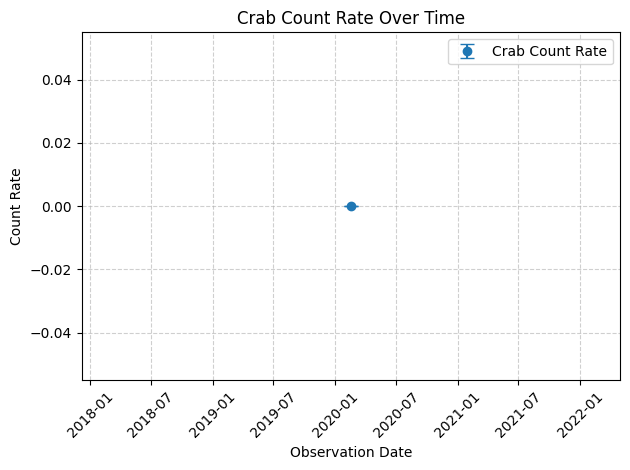

In [ ]:
from datetime import datetime

obs_times = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S") for date in obs_start_dates]

crab_countrates = np.array(crab_countrates)
crab_variances = np.array(crab_variances)
errors = np.sqrt(crab_variances)
offsets = np.array(offsets)

# Plot count rate over time with errorbars
plt.figure()
plt.errorbar(obs_times, crab_countrates, yerr=errors, fmt='o', capsize=5, label="Crab Count Rate")
plt.xlabel("Observation Date")
plt.ylabel("Count Rate")
plt.title("Crab Count Rate Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# Plot angular offset from pointing center over time
plt.figure()
plt.scatter(obs_times, offsets, label="Crab Count Rate")
plt.xlabel("Observation Date")
plt.ylabel("Angular offset")
plt.title("Crab Angular Offset Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

## LIGHT CURVE

In [ ]:
lc_disp_by_date = {}
lc_data_by_date = {}

while True:
    lightcurve_results = []

    for year_month in set(year_months):

        filtered_scws = []
        for i, year_month_in_list in enumerate(year_months):
            if year_month_in_list == year_month:
                filtered_scws.append((scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i]))

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue

        min_duration_scw = min(filtered_scws, key=lambda x: x[3]) # minimum duration
        scw_id, start_time, end_time, duration = min_duration_scw

        par_dict = {
            "RA": ra,
            "DEC": dec,
            "E1_keV": "15",
            "E2_keV": "30", 
            "T_format": "isot",
            'T1': start_time,
            'T2': end_time,
            "time_bin": duration_seconds, 
            "instrument": "isgri",
            "osa_version": "OSA11.2",
            "product": "isgri_lc",
            "product_type": "Real",
            "scw_list": [scw_id],
            'token': oda_api.token.discover_token(),
            'selected_catalog': json.dumps(api_cat)
            }
        
        if scw_id not in lc_disp_by_date:
            lc_disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)
        
        _disp = lc_disp_by_date[scw_id]
        
        data = lc_data_by_date.get(scw_id, None)

        if data is None and not _disp.is_failed:
            if not _disp.is_submitted:
                data = _disp.get_product(**par_dict)
            else:
                _disp.poll()

            print("Is complete ", _disp.is_complete)
            if not _disp.is_complete:
                continue
            else:
                data = _disp.get_product(**par_dict)
                lc_data_by_date[scw_id] = data

        lightcurve_results.append(data)

    n_complete = len([ year for year, _disp in lc_disp_by_date.items() if _disp.is_complete ])
    print(f"complete {n_complete} / {len(lc_disp_by_date)}")
    if n_complete == len(lc_disp_by_date):
        print("done!")
        break
    print("not done")

Light curve analysis.

## COMPARISON
Here we compare the count rate of the Crab over time between the two methods (using images or light curves).